# <center> Homework 7: Support Vector Machines </center>
<center> Anushna Prakash </center>
<center> May 28, 2021 </center>

$$ \min_{\alpha \in \mathbb{R}^n} F(\alpha):= \frac{1}{n} \sum_{i=1}^{n} \ell(y_i, (K\alpha)_i) + \lambda \alpha^T K \alpha$$  
$$ \min_{\alpha \in \mathbb{R}^n} F(\alpha):= \frac{1}{n} \sum_{i=1}^{n} (\max \{0, 1 - y_i (K\alpha)_i\})^2 + \lambda \alpha^T K \alpha$$  
$$ \nabla F(\alpha) = -\frac{2}{n} \sum_{i=1}^{n} K_i y_i  \max \{0, 1-y_i K_i^T \alpha\} + 2\lambda K \alpha $$  
$$
    \nabla F(\alpha) = 
    \begin{cases}
        -\frac{2}{n} \sum_{i=1}^{n} K_i y_i (1 - y_i K_i^T \alpha) + 2 \lambda K \alpha, & \text{for } 1-y_i(K\alpha)_i > 0\\
        2 \lambda K \alpha, & \text{for } 1-y_i(K\alpha)_i <= 0\\
    \end{cases}
$$

In [30]:
import numpy as np
import pandas as pd
from sklearn.datasets import load_digits
from sklearn.preprocessing import normalize
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

In [31]:
def kernal(x, y, b, p):
    return ((x @ y.T) + b)**p

In [32]:
def computegram(k, x, b, p):
#     n = x.shape[0]
#     K = np.empty(shape = (n, n))
    
#     for i, v in enumerate(x):
#         for j, w in enumerate(x):
#             K[i][j] = k(v, w, b, p)
    K = k(x, x, b, p)
    return K

In [33]:
def kernaleval(k, x, x_star, b, p):
    kernal_evals = np.empty(len(x))
    for i, v in enumerate(x):
        kernal_evals[i] = k(v, x_star, b, p)
    
    return kernal_evals

In [34]:
def svm_f(alpha, gram, X, y, lambda_):
    n = X.shape[0]
    K_a = np.dot(gram, alpha)
#     loss = 0
#     for i in range(n):
#         cond = 1.0 - y[i] * K_a[i]
#         if cond > 0:
#             loss += np.square(cond)
    loss = 1.0 - np.multiply(y, K_a)
    loss_condition = np.where(loss > 0, loss, 0)

    return np.mean(np.square(loss_condition)) + lambda_ * (alpha.T @ gram @ alpha)

In [35]:
def svm_grad(alpha, gram, X, y, lambda_):
    n = len(X)
    K_a = np.dot(gram, alpha)
    loss = 1.0 - np.multiply(y, np.dot(gram, alpha))
    reg = 2.0 * lambda_ * K_a
    loss_grad = np.zeros(reg.shape)
    
    for i in range(n):
        if loss[i] > 0:
            K_y = gram[i] * y[i]
            loss_grad += -2 * K_y * loss[i]
        
    return (1/n) * loss_grad + reg

In [36]:
def backtracking(eta_init, decay_rate, prop_constant, alpha, *args):
    eta = eta_init
    
    def decrease_condition(eta):
        grad = svm_grad(alpha, *args)
        left = svm_f(alpha - eta * grad, *args) - svm_f(alpha, *args)
        right = -eta * prop_constant * np.linalg.norm(grad)**2
        return left <= right
    
    while not decrease_condition(eta):
        eta *= decay_rate
    
    return eta

In [37]:
def mysvm(eta_init, tol, alpha_init, *args):
    theta = alpha_init.copy()
    alpha = alpha_init.copy()
    iters = [alpha]
    grad = svm_grad(alpha, *args)
    decay_rate = 0.3
    prop_constant = 0.3
    t = 0
    
    while np.linalg.norm(grad) > tol:
#         print(grad)
        eta = backtracking(eta_init, decay_rate, prop_constant, theta, *args)
        alpha_t = theta - eta * svm_grad(theta, *args)
        theta = alpha_t + (t/(t + 3)) * (alpha_t - alpha)
        grad = svm_grad(alpha_t, *args)
        iters.append(alpha_t)
        alpha = alpha_t
        t += 1
    
    return iters

In [38]:
# Download the data
digits = load_digits().data
y = load_digits().target

# Normalize and split 80/20 training and test
digits = normalize(digits, norm = 'l2', axis = 1)
X_train, X_test, y_train, y_test = train_test_split(digits, y, train_size = 0.8, random_state = 12345)

In [39]:
digits = np.unique(y)
classifiers = {}

In [40]:
y_train_0 = np.where(y_train == 0, 1, -1)
eta_init = 0.000001
tol = 1.0
alpha_init = np.zeros(X_train.shape[0])
lam = 10.0
b = 1
p = 7
K = computegram(kernal, X_train, b, p)
svm_d = mysvm(eta_init, tol, alpha_init, K, X_train, y_train_0, lam)

In [41]:
obj = [svm_f(a, K, X_train, y_train_0, lam) for a in svm_d]

Text(0, 0.5, 'SVM Objective Hinge Loss')

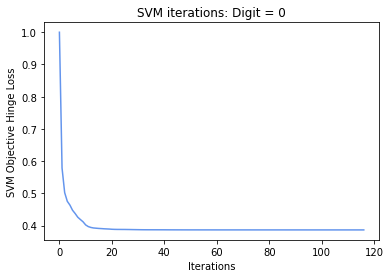

In [42]:
plt.plot(obj, c = 'cornflowerblue')
plt.title('SVM iterations: Digit = 0')
plt.xlabel('Iterations')
plt.ylabel('SVM Objective Hinge Loss')

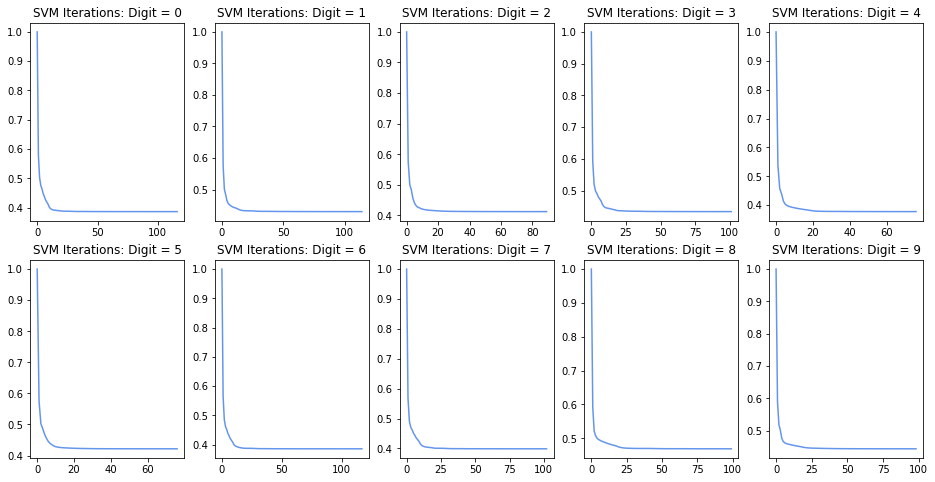

In [49]:
eta_init = 0.000001
tol = 1.0
alpha_init = np.zeros(X_train.shape[0])
lam = 10.0
b = 1
p = 7
K = computegram(kernal, X_train, b, p)

fig, axs = plt.subplots(2, 5, figsize = (16, 8))
for d in digits:
    row = np.where(d < 5, 0, 1)
    col = d % 5
    title = 'SVM Iterations: Digit = ' + str(d)
    # train a classifier on y_i^d = 1 if y_i = d, -1 else
    y_train_d = np.where(y_train == d, 1, -1)
    svm_d = mysvm(eta_init, tol, alpha_init, K, X_train, y_train_d, lam)
    classifiers[d] = svm_d[-1]
    obj = [svm_f(a, K, X_train, y_train_d, lam) for a in svm_d]
    axs[row, col].plot(obj, c = 'cornflowerblue')
    axs[row, col].set_title(title)